In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808327 sha256=978d14a50e660001fa94ca9f7ae3d6b492456e92b8330328cfba7ce278fd253e
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [2]:
import pandas as pd
import numpy as np
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, auc_score, reciprocal_rank
from lightfm.cross_validation import random_train_test_split
import matplotlib.pyplot as plt
import joblib

In [3]:
# Load your data
users_df = pd.read_csv('/content/drive/MyDrive/recommendation_service_dataset/users.csv')
products_df = pd.read_csv('/content/drive/MyDrive/recommendation_service_dataset/products.csv')
events_df = pd.read_csv('/content/drive/MyDrive/recommendation_service_dataset/events.csv')


In [4]:
# Preprocessing
events_df['product_id'] = events_df.apply(lambda row: int(row['uri'].split('/')[-1]) if '/product/' in row['uri'] else np.nan, axis=1)

events_df = events_df.dropna(subset=['product_id', 'user_id'])

events_df.loc[:, 'user_id'] = events_df['user_id'].astype(int)
events_df.loc[:, 'product_id'] = events_df['product_id'].astype(int)

filtered_events = events_df[events_df['user_id'].isin(users_df['id']) & events_df['product_id'].isin(products_df['id'])]

# Add age group feature to users
users_df['age_group'] = pd.cut(users_df['age'], bins=[0, 18, 25, 35, 45, 55, 65, 100], labels=['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '65+'])


print(filtered_events.head())
print(users_df.head())


           id  user_id  sequence_number                            session_id  \
15378  938936  72066.0                8  977abd27-0d66-4af1-bf8a-424ae311ff45   
15380  225805  17033.0                8  fb5fd04f-83b8-448a-84d3-4864a0873a63   
15382   57185   4292.0                2  b92bb449-4da4-4fc6-a113-b06d5ae91116   
15383   91847   6942.0                5  16cd1dfd-f206-41cc-9a01-92b1c6b48ffa   
15385  920430  70661.0                3  fe3f6125-f804-4fc5-b891-2e66f70ebf70   

                    created_at      ip_address       city      state  \
15378  2024-02-04 05:42:27 UTC  50.204.179.168  São Paulo  São Paulo   
15380  2022-09-22 05:43:27 UTC  52.156.208.189  São Paulo  São Paulo   
15382  2021-07-16 01:41:36 UTC  129.217.221.84  São Paulo  São Paulo   
15383  2023-11-06 09:30:13 UTC  74.169.206.224  São Paulo  São Paulo   
15385  2023-07-12 13:44:21 UTC  154.57.135.173  São Paulo  São Paulo   

      postal_code  browser traffic_source             uri event_type  \
15378   

In [5]:
# Prepare the dataset
dataset = Dataset()
dataset.fit(
    users=(x for x in users_df['id']),
    items=(x for x in products_df['id']),
    user_features=(f"{row['gender']}_{row['age_group']}_{row['state']}" for index, row in users_df.iterrows()),
    item_features=(f"{row['category']}_{row['brand']}" for index, row in products_df.iterrows())
)

(interactions_matrix, weights_matrix) = dataset.build_interactions(
    (row['user_id'], row['product_id']) for index, row in filtered_events.iterrows()
)

user_features = dataset.build_user_features(
    (row['id'], [f"{row['gender']}_{row['age_group']}_{row['state']}"])
    for index, row in users_df[users_df['id'].isin(filtered_events['user_id'])].iterrows()
)

item_features = dataset.build_item_features(
    (row['id'], [f"{row['category']}_{row['brand']}"])
    for index, row in products_df[products_df['id'].isin(filtered_events['product_id'])].iterrows()
)



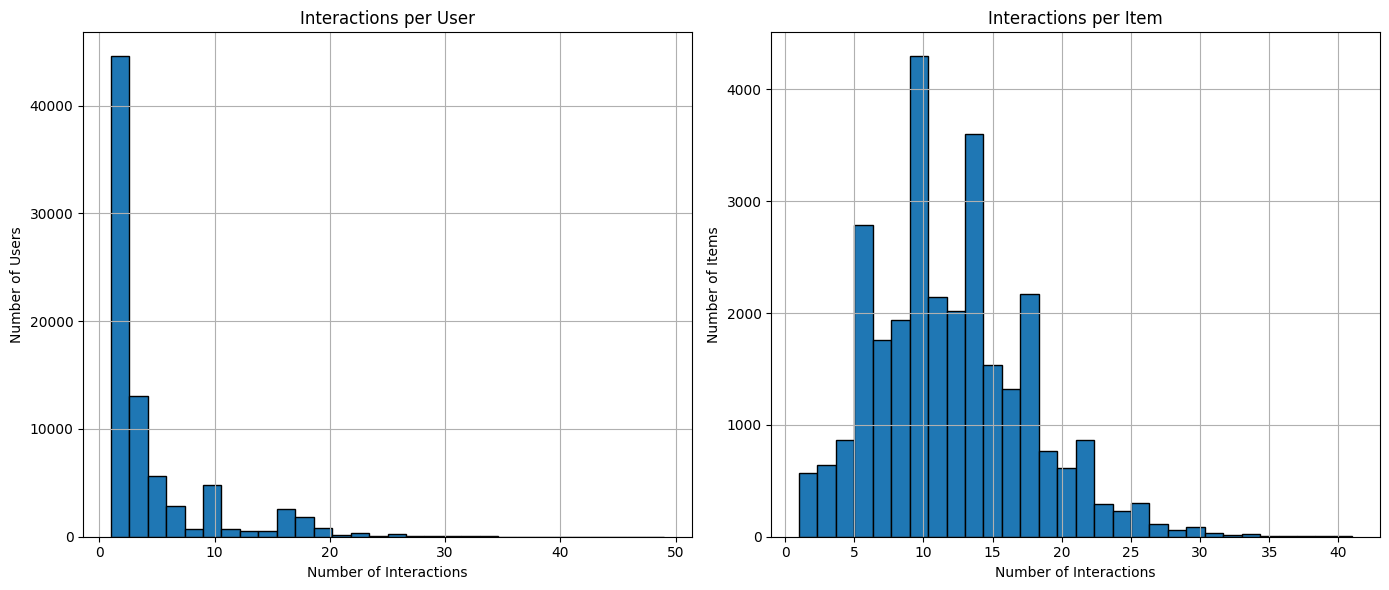

In [6]:
import matplotlib.pyplot as plt

# Assuming 'filtered_events' is your final events DataFrame after preprocessing
# Interactions per User
user_interactions = filtered_events.groupby('user_id').size()
item_interactions = filtered_events.groupby('product_id').size()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
user_interactions.hist(bins=30, edgecolor='black')
plt.title('Interactions per User')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')

plt.subplot(1, 2, 2)
item_interactions.hist(bins=30, edgecolor='black')
plt.title('Interactions per Item')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Items')

plt.tight_layout()
plt.show()


In [7]:
# Split the data into training and testing sets
train, test = random_train_test_split(interactions_matrix, test_percentage=0.2, random_state=np.random.RandomState(42))

# Initialize the LightFM model with WARP loss function
model = LightFM(loss='warp', no_components=30, user_alpha=1e-4, item_alpha=1e-4)


In [8]:
from lightfm.evaluation import reciprocal_rank

# Train the model with less frequent evaluations
num_epochs = 50
evaluation_interval = 5  # Evaluate every 5 epochs
for epoch in range(num_epochs):
    model.fit_partial(train, user_features=user_features, item_features=item_features, epochs=1)

    if (epoch + 1) % evaluation_interval == 0:
        train_rr = reciprocal_rank(model, train, user_features=user_features, item_features=item_features).mean()
        test_rr = reciprocal_rank(model, test, user_features=user_features, item_features=item_features).mean()
        print(f'Epoch: {epoch+1} - Train Reciprocal Rank: {train_rr:.4f}, Test Reciprocal Rank: {test_rr:.4f}')



Epoch: 5 - Train Reciprocal Rank: 0.0064, Test Reciprocal Rank: 0.0034
Epoch: 10 - Train Reciprocal Rank: 0.0169, Test Reciprocal Rank: 0.0081
Epoch: 15 - Train Reciprocal Rank: 0.0311, Test Reciprocal Rank: 0.0137
Epoch: 20 - Train Reciprocal Rank: 0.0464, Test Reciprocal Rank: 0.0194
Epoch: 25 - Train Reciprocal Rank: 0.0637, Test Reciprocal Rank: 0.0255
Epoch: 30 - Train Reciprocal Rank: 0.0806, Test Reciprocal Rank: 0.0313
Epoch: 35 - Train Reciprocal Rank: 0.0967, Test Reciprocal Rank: 0.0371
Epoch: 40 - Train Reciprocal Rank: 0.1117, Test Reciprocal Rank: 0.0417
Epoch: 45 - Train Reciprocal Rank: 0.1258, Test Reciprocal Rank: 0.0458
Epoch: 50 - Train Reciprocal Rank: 0.1391, Test Reciprocal Rank: 0.0497


In [9]:
# Final evaluation at the end of training
train_precision = precision_at_k(model, train, k=10, user_features=user_features, item_features=item_features).mean()
test_precision = precision_at_k(model, test, k=10, user_features=user_features, item_features=item_features).mean()
train_auc = auc_score(model, train, user_features=user_features, item_features=item_features).mean()
test_auc = auc_score(model, test, user_features=user_features, item_features=item_features).mean()

print('Final evaluation results:')
print(f'Precision: Train {train_precision:.4f}, Test {test_precision:.4f}')
print(f'AUC: Train {train_auc:.4f}, Test {test_auc:.4f}')


Final evaluation results:
Precision: Train 0.0387, Test 0.0145
AUC: Train 0.9771, Test 0.8578


In [13]:
# Sample recommendation function
def sample_recommendation(model, user_id, user_features, item_features, dataset, num_items=10):
    n_users, n_items = dataset.interactions_shape()
    user_x = dataset.mapping()[0][user_id]
    scores = model.predict(user_x, np.arange(n_items), user_features=user_features, item_features=item_features)
    top_items = np.argsort(-scores)[:num_items]

    return [dataset.mapping()[2][i] for i in top_items]

# Test the recommendation function for a specific user 17033
user_id = 17033
recommended_products = sample_recommendation(model, user_id, user_features, item_features, dataset)
print(f'Recommended product IDs for user {user_id}: {recommended_products}')

Recommended product IDs for user 17033: [19074, 3958, 6720, 20665, 18234, 16547, 25161, 9218, 21771, 22778]
